In [5]:
import os
os.chdir('/Users/nick/Documents/school/research/EfficientLPR')
import tensorflow as tf
# model = tf.saved_model.load('saved_model')
model = tf.keras.models.load_model('saved_model/saved_model.pb')

TypeError: load_model() got an unexpected keyword argument 'format'

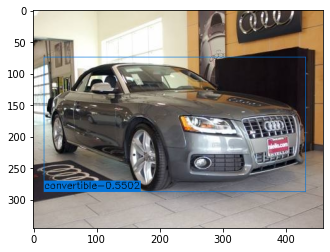

In [3]:
from cv2 import cv2
import glob
import matplotlib.pyplot as plt
from utils import preprocess_image, postprocess_boxes
from utils.draw_boxes import draw_boxes
import numpy as np
import pandas as pd

infer = model.signatures["serving_default"]


img_dir = 'data/processed/stanford-cars/train'

classes = [x[0] for x in pd.read_csv('data/processed/classes.csv', header=None).values]
color_classes = [x[0] for x in pd.read_csv('data/processed/colors.csv', header=None).values]
num_colors = len(color_classes)
num_classes = len(classes)
colors = [np.random.randint(0, 256, 3).tolist() for _ in range(num_classes)]

from random import random
for path in glob.glob(img_dir +'/*')[:3]:
    image = cv2.imread(path)
    src_image = image.copy()
    image = image[:,:,::-1]
    h, w = image.shape[:2]
    image, scale = preprocess_image(image, 512)

    out = infer(tf.constant(tf.expand_dims(image, 0)))
    boxes, scores, labels = out['filtered_detections'], out['filtered_detections_1'], out['filtered_detections_2']
    color_preds = out['colors'].numpy()
    boxes, scores, labels = np.squeeze(boxes), np.squeeze(scores), np.squeeze(labels)
    boxes = postprocess_boxes(boxes=boxes.copy(), scale=scale, height=h, width=w)

    # get best bbox and all class predictions for csv
    i_best = np.argmax(scores)
    best_bbox = boxes[i_best]
    best_label = labels[i_best]
    best_color = color_classes[np.argmax(color_preds)]
    draw_boxes(src_image, [best_bbox], [scores[i_best]], [best_label], colors, classes)

    plt.imshow(src_image[:,:,::-1])